In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Sergipe - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_SE.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Sergipe- custo m2 (R$),Sergipe - IDH Educacao,Sergipe - IDH,Sergipe - Depósito Poupança (R$),Sergipe - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - Consumo de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - IDH Renda,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,9513.254800,0.599319,0.669217,1.618045e+06,0.750379,1.154340,1013.090299,2716.496979,26.501337,23.889841,80.366597,3.552746,0.339447,152.791400,23.616,2.159732e+07,1.260978e+06,9.960678,2.029642e+07,0.648121,8.389943,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,9606.199031,0.599716,0.669542,1.622416e+06,0.750793,1.155152,1013.092341,2716.496979,26.502125,23.879336,80.334711,3.551254,0.341257,151.964054,21.357,2.162153e+07,1.262134e+06,9.961956,2.030238e+07,0.648377,8.384067,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,9693.715697,0.600113,0.669868,1.626787e+06,0.751207,1.155625,1013.093533,2716.496979,26.502585,23.873208,80.316112,3.550384,0.343016,154.467758,20.059,2.164574e+07,1.263289e+06,9.963234,2.030833e+07,0.648633,8.378190,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,9777.797840,0.600511,0.670193,1.631158e+06,0.751620,1.155676,1013.093660,2716.496979,26.502635,23.872551,80.314119,3.550291,0.344722,155.913400,19.920,2.166995e+07,1.264444e+06,9.964512,2.031429e+07,0.648889,8.372313,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,9852.699220,0.600908,0.670519,1.635529e+06,0.752034,1.195157,1012.797543,2575.798720,26.636934,23.787977,79.846291,3.554977,0.346174,157.467159,19.962,2.169416e+07,1.265599e+06,9.965790,2.032025e+07,0.649145,8.366437,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,33548.705040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,33497.662935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,33431.682561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,33345.640179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


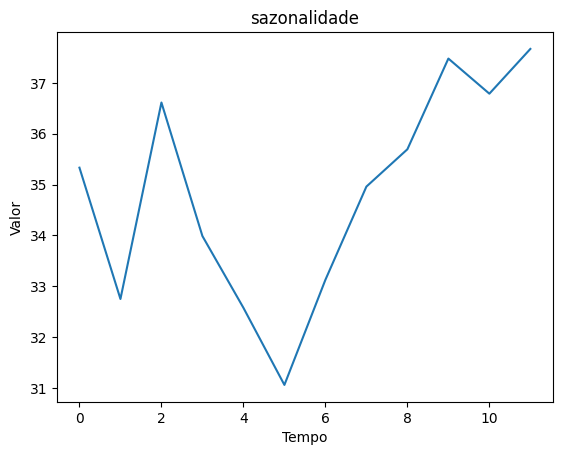

,sazonalidade
sazonalidade,
0,35.332262
1,32.751437
2,36.612531
3,33.988033
4,32.578400
5,31.062565
6,33.128152
7,34.959926
8,35.693481


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Sergipe- custo m2 (R$),Sergipe - IDH Educacao,Sergipe - IDH,Sergipe - Depósito Poupança (R$),Sergipe - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - IDH Renda,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Sergipe - Consumo de Cimento (t)
0,2003-1,9513.254800,0.599319,0.669217,1.618045e+06,0.750379,1.154340,1013.090299,2716.496979,26.501337,23.889841,80.366597,3.552746,0.339447,152.791400,2.159732e+07,1.260978e+06,9.960678,2.029642e+07,0.648121,8.389943,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,35.332262,23.616
1,2003-2,9606.199031,0.599716,0.669542,1.622416e+06,0.750793,1.155152,1013.092341,2716.496979,26.502125,23.879336,80.334711,3.551254,0.341257,151.964054,2.162153e+07,1.262134e+06,9.961956,2.030238e+07,0.648377,8.384067,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,32.751437,21.357
2,2003-3,9693.715697,0.600113,0.669868,1.626787e+06,0.751207,1.155625,1013.093533,2716.496979,26.502585,23.873208,80.316112,3.550384,0.343016,154.467758,2.164574e+07,1.263289e+06,9.963234,2.030833e+07,0.648633,8.378190,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,36.612531,20.059
3,2003-4,9777.797840,0.600511,0.670193,1.631158e+06,0.751620,1.155676,1013.093660,2716.496979,26.502635,23.872551,80.314119,3.550291,0.344722,155.913400,2.166995e+07,1.264444e+06,9.964512,2.031429e+07,0.648889,8.372313,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,33.988033,19.920
4,2003-5,9852.699220,0.600908,0.670519,1.635529e+06,0.752034,1.195157,1012.797543,2575.798720,26.636934,23.787977,79.846291,3.554977,0.346174,157.467159,2.169416e+07,1.265599e+06,9.965790,2.032025e+07,0.649145,8.366437,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,32.578400,19.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,33548.705040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.578400,NaN
245,2023-6,33497.662935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.062565,NaN
246,2023-7,33431.682561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.128152,NaN
247,2023-8,33345.640179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.959926,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      18.244
1      18.161
2      23.259
3      19.137
4      15.066
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Sergipe - Consumo de Cimento (t), Length: 249, dtype: float64

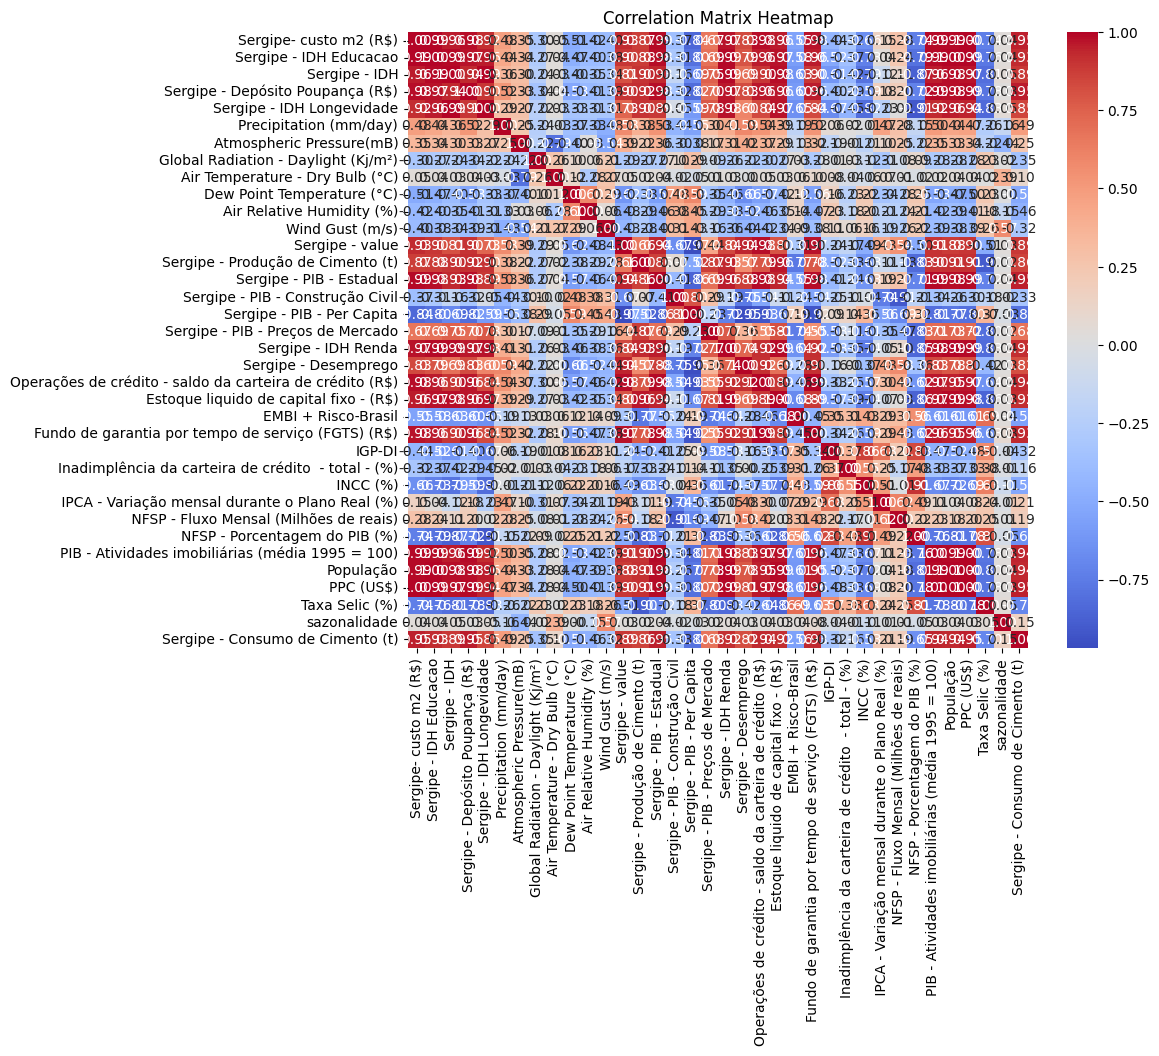

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Sergipe- custo m2 (R$),3.081134e+05
1,Sergipe - IDH Educacao,2.779528e+10
2,Sergipe - IDH,1.422174e+07
3,Sergipe - Depósito Poupança (R$),3.489822e+05
4,Sergipe - IDH Longevidade,2.093364e+10
5,Precipitation (mm/day),6.723169e+00
6,Atmospheric Pressure(mB),3.314900e+01
7,Global Radiation - Daylight (Kj/m²),2.193728e+01
8,Air Temperature - Dry Bulb (°C),3.942508e+01
9,Dew Point Temperature (°C),1.189649e+01


In [39]:
data =data.drop(['Air Temperature - Dry Bulb (°C)', 
                 'Wind Gust (m/s)',
                 'Global Radiation - Daylight (Kj/m²)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 10


,Sergipe- custo m2 (R$),Sergipe - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,9513.254800,1.618045e+06,1.154340,1013.090299,2716.496979,26.501337,23.889841,80.366597,3.552746,0.339447,152.791400,8.389943,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,35.332262
1,9606.199031,1.622416e+06,1.155152,1013.092341,2716.496979,26.502125,23.879336,80.334711,3.551254,0.341257,151.964054,8.384067,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,32.751437
2,9693.715697,1.626787e+06,1.155625,1013.093533,2716.496979,26.502585,23.873208,80.316112,3.550384,0.343016,154.467758,8.378190,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,36.612531
3,9777.797840,1.631158e+06,1.155676,1013.093660,2716.496979,26.502635,23.872551,80.314119,3.550291,0.344722,155.913400,8.372313,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,33.988033
4,9852.699220,1.635529e+06,1.195157,1012.797543,2575.798720,26.636934,23.787977,79.846291,3.554977,0.346174,157.467159,8.366437,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,32.578400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,20779.589545,3.441408e+06,1.507766,1015.347895,1369.614412,26.226519,18.756205,64.257604,2.597560,0.488526,222.795056,13.794572,3.143856e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,390.589413,1.078474,34.959926
152,20851.402371,3.435384e+06,1.347006,1014.895830,1465.100290,26.543833,19.023019,64.011703,3.070758,0.488677,220.203193,13.821567,3.159665e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,391.798431,0.962516,35.693481
153,20920.241874,3.429361e+06,1.320124,1014.281915,1481.822128,26.769262,19.458104,64.868873,3.372049,0.488845,218.109389,13.848563,3.177292e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,393.032398,1.138989,37.476625
154,20992.978540,3.423338e+06,1.290403,1013.798963,1518.990064,27.113283,19.823885,64.990754,3.434318,0.488808,216.063839,13.875558,3.192250e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,394.326420,1.038436,36.786410


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Sergipe - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.437751,-0.510460,-0.374806,-0.027592,-0.244016,0.860629,0.784236,0.661453,-1.160955,-1.821206,-0.643322,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,-1.431599,-0.508685,-0.373150,-0.027592,-0.242870,0.856725,0.780502,0.658258,-1.122519,-1.843076,-0.645974,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,-1.425446,-0.507650,-0.372183,-0.027592,-0.242202,0.854448,0.778324,0.656395,-1.085162,-1.776894,-0.648625,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,-1.419294,-0.507539,-0.372080,-0.027592,-0.242130,0.854204,0.778090,0.656195,-1.048923,-1.738681,-0.651276,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,-1.413141,-0.421206,-0.612283,-0.056990,-0.046967,0.822777,0.723303,0.666232,-1.018083,-1.697609,-0.653927,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1.128765,0.262388,1.456503,-0.309014,-0.643379,-1.046979,-1.102272,-1.384255,2.004846,0.029243,1.794976,1.823582,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.398025,0.209123
152,1.120287,-0.089152,1.089798,-0.289063,-0.182261,-0.947833,-1.131069,-0.370813,2.008061,-0.039269,1.807155,1.841017,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.415152,-0.182135
153,1.111808,-0.147935,0.591805,-0.285569,0.145332,-0.786160,-1.030687,0.274457,2.011620,-0.094616,1.819334,1.860456,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.432633,0.413308
154,1.103330,-0.212928,0.200045,-0.277803,0.645260,-0.650240,-1.016414,0.407819,2.010835,-0.148687,1.831513,1.876950,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.450965,0.074029


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Sergipe - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.437751,-0.510460,-0.374806,-0.027592,-0.244016,0.860629,0.784236,0.661453,-1.160955,-1.821206,-0.643322,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,-1.431599,-0.508685,-0.373150,-0.027592,-0.242870,0.856725,0.780502,0.658258,-1.122519,-1.843076,-0.645974,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,-1.425446,-0.507650,-0.372183,-0.027592,-0.242202,0.854448,0.778324,0.656395,-1.085162,-1.776894,-0.648625,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,-1.419294,-0.507539,-0.372080,-0.027592,-0.242130,0.854204,0.778090,0.656195,-1.048923,-1.738681,-0.651276,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,-1.413141,-0.421206,-0.612283,-0.056990,-0.046967,0.822777,0.723303,0.666232,-1.018083,-1.697609,-0.653927,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.320270,0.176081,1.678046,-0.320615,-0.944600,-0.976950,-0.466925,-0.753870,1.709539,0.816397,1.614649,1.517172,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.245801,-0.282621
140,1.293839,-0.197619,1.232507,-0.308819,-0.581159,-0.613146,-0.260396,-0.154757,1.753057,0.767622,1.633664,1.549848,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.254608,-0.612121
141,1.267407,-0.256148,0.874082,-0.295700,-0.076070,-0.388559,-0.220869,0.277581,1.793116,0.717028,1.652679,1.588878,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.263636,-0.137902
142,1.240976,-0.170282,0.415603,-0.288228,0.353632,-0.156579,-0.120381,0.423320,1.831123,0.664847,1.671694,1.625721,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.272935,-0.332143


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      18.244000
1      18.161000
2      23.259000
3      19.137000
4      15.066000
         ...    
139    45.144123
140    46.221200
141    49.333447
142    47.003868
143    44.845000
Name: Sergipe - Consumo de Cimento (t), Length: 144, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 23)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Sergipe - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
108,0.762352,0.324903,-0.580166,-0.281119,0.642969,-0.152736,-0.389143,0.329565,0.469642,1.006374,0.909853,0.595959,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.812014,-1.082183
109,0.796589,0.755338,-0.418001,-0.287343,0.684168,-0.184813,-0.442743,-0.115423,0.488495,1.041756,0.936091,0.621380,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.831569,-1.036767
110,0.830826,0.390779,0.017318,-0.303607,0.442515,-0.265318,-0.467735,-0.573150,0.506969,1.080880,0.962330,0.652999,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.850791,-0.752482
111,0.865063,0.488126,0.550342,-0.324368,-0.072425,-0.378646,-0.445387,-1.091492,0.533713,1.093847,0.988568,0.685630,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.868783,-1.088413
112,0.899300,0.652465,1.359998,-0.339523,-0.760694,-0.516095,-0.402741,-1.417800,0.560222,1.117177,1.014806,0.717515,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.886720,-1.508135
113,0.933538,0.605629,1.952285,-0.342659,-1.220378,-0.610901,-0.377456,-1.430868,0.590813,1.132991,1.041045,0.747579,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.905151,-1.474280
114,0.967775,0.574941,2.056982,-0.336089,-1.470085,-0.727946,-0.375191,-1.204187,0.621318,1.151997,1.067283,0.775262,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.923702,-1.463452
115,1.002012,0.486030,1.688226,-0.320664,-1.283936,-1.673540,-1.181785,-0.444973,0.651729,1.185730,1.093522,0.805205,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.942382,-1.236037
116,1.036249,0.233167,0.985151,-0.303004,-0.785499,-2.911056,-2.250749,0.222104,0.682040,1.226120,1.119760,0.836796,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.960385,-0.935721
117,1.070486,-0.274109,0.270505,-0.290915,-0.243079,-3.089561,-2.462829,0.817058,0.712244,1.253278,1.145999,0.876422,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.977769,-1.241995


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 23)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2362119113, 1595470840, 628299578, 2628207206, 2242044635, 3103605740, 3663018800, 1252083820, 2839504264, 1812746201]


Step: 0 ___________________________________________
val_loss: 10.486270904541016
winner_seed: 2362119113


Step: 1 ___________________________________________
val_loss: 26.104703903198242


Step: 2 ___________________________________________
val_loss: 5.234012603759766
winner_seed: 628299578


Step: 3 ___________________________________________
val_loss: 6.727411270141602


Step: 4 ___________________________________________
val_loss: 4.849433422088623
winner_seed: 2242044635


Step: 5 ___________________________________________
val_loss: 7.489861488342285


Step: 6 ___________________________________________
val_loss: 10.013781547546387


Step: 7 ___________________________________________
val_loss: 5.172995567321777


Step: 8 ___________________________________________
val_loss: 8.812826156616211


Step: 9 ___________________________________________
val_loss: 6.19

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 113ms/step - loss: 1860.2220 - val_loss: 10.7755
Epoch 2/10000
4/4 [==============================] - 0s 8ms/step - loss: 76.2166 - val_loss: 29.2782
Epoch 3/10000
4/4 [==============================] - 0s 7ms/step - loss: 83.8643 - val_loss: 10.4387
Epoch 4/10000
4/4 [==============================] - 0s 8ms/step - loss: 67.0271 - val_loss: 17.8678
Epoch 5/10000
4/4 [==============================] - 0s 8ms/step - loss: 54.8410 - val_loss: 167.6382
Epoch 6/10000
4/4 [==============================] - 0s 8ms/step - loss: 107.0079 - val_loss: 55.3861
Epoch 7/10000
4/4 [==============================] - 0s 8ms/step - loss: 69.2328 - val_loss: 48.6971
Epoch 8/10000
4/4 [==============================] - 0s 8ms/step - loss: 56.3550 - val_loss: 179.7672
Epoch 9/10000
4/4 [==============================] - 0s 7ms/step - loss: 58.2483 - val_loss: 67.4250
Epoch 10/10000
4/4 [==============================] - 0s 8ms/step - loss: 23.2011 - 

4/4 [==============================] - 0s 9ms/step - loss: 14.9949 - val_loss: 15.9159
Epoch 82/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.5154 - val_loss: 10.8836
Epoch 83/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.6478 - val_loss: 14.2531
Epoch 84/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.3088 - val_loss: 11.6927
Epoch 85/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.2583 - val_loss: 46.2847
Epoch 86/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.0914 - val_loss: 4.5193
Epoch 87/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.5547 - val_loss: 27.1397
Epoch 88/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.6934 - val_loss: 18.3722
Epoch 89/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.1829 - val_loss: 9.1892
Epoch 90/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.7928 - val_loss: 8.5168


4/4 [==============================] - 0s 9ms/step - loss: 9.0560 - val_loss: 6.5023
Epoch 162/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.3590 - val_loss: 20.7955
Epoch 163/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.7332 - val_loss: 13.1658
Epoch 164/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.9623 - val_loss: 3.6437
Epoch 165/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.4047 - val_loss: 29.8962
Epoch 166/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.2047 - val_loss: 12.9269
Epoch 167/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.1906 - val_loss: 9.9222
Epoch 168/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.2956 - val_loss: 38.4161
Epoch 169/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.9180 - val_loss: 3.6916
Epoch 170/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.6751 - val_loss: 6.

4/4 [==============================] - 0s 8ms/step - loss: 11.6851 - val_loss: 16.3389
Epoch 242/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.5358 - val_loss: 28.6240
Epoch 243/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.2494 - val_loss: 26.2226
Epoch 244/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.8693 - val_loss: 35.7982
Epoch 245/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.7357 - val_loss: 10.6512
Epoch 246/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.3538 - val_loss: 15.3685
Epoch 247/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.0629 - val_loss: 6.6520
Epoch 248/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.9190 - val_loss: 7.0563
Epoch 249/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.8420 - val_loss: 3.8203
Epoch 250/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.8407 - val_loss: 10.12

4/4 [==============================] - 0s 9ms/step - loss: 6.5866 - val_loss: 19.5101
Epoch 322/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.3903 - val_loss: 21.4825
Epoch 323/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.4461 - val_loss: 18.1754
Epoch 324/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.2283 - val_loss: 28.7072
Epoch 325/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.9529 - val_loss: 21.2618
Epoch 326/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.1729 - val_loss: 20.4152
Epoch 327/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.5404 - val_loss: 15.6388
Epoch 328/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.5622 - val_loss: 18.1649
Epoch 329/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.0400 - val_loss: 24.2603
Epoch 330/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.0038 - val_loss: 41

4/4 [==============================] - 0s 8ms/step - loss: 5.3525 - val_loss: 26.1684
Epoch 402/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3580 - val_loss: 25.3687
Epoch 403/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.2439 - val_loss: 27.2892
Epoch 404/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.3994 - val_loss: 30.5562
Epoch 405/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.2837 - val_loss: 34.2460
Epoch 406/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.6510 - val_loss: 15.6934
Epoch 407/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.9407 - val_loss: 55.3148
Epoch 408/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.0207 - val_loss: 36.6237
Epoch 409/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.1485 - val_loss: 47.4597
Epoch 410/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.8438 - val_loss: 80.

4/4 [==============================] - 0s 10ms/step - loss: 5.2524 - val_loss: 30.6204
Epoch 482/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.8334 - val_loss: 9.6573
Epoch 483/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.3556 - val_loss: 13.0700
Epoch 484/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.8685 - val_loss: 31.2569
Epoch 485/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.1223 - val_loss: 24.8138
Epoch 486/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.7663 - val_loss: 54.3253
Epoch 487/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.5348 - val_loss: 24.4189
Epoch 488/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.0017 - val_loss: 30.8111
Epoch 489/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.9782 - val_loss: 13.8646
Epoch 490/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.8202 - val_loss: 33.8

4/4 [==============================] - 0s 8ms/step - loss: 5.4352 - val_loss: 35.2356
Epoch 562/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.4259 - val_loss: 20.2780
Epoch 563/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.3985 - val_loss: 24.2919
Epoch 564/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.4982 - val_loss: 27.0779
Epoch 565/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.8932 - val_loss: 26.0256
Epoch 566/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.5714 - val_loss: 19.3847
Epoch 567/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.8858 - val_loss: 36.8932
Epoch 568/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.4065 - val_loss: 36.6969
Epoch 569/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7237 - val_loss: 27.6305
Epoch 570/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.2141 - val_loss: 23.6

4/4 [==============================] - 0s 8ms/step - loss: 5.5449 - val_loss: 33.2261
Epoch 642/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3401 - val_loss: 26.8516
Epoch 643/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7257 - val_loss: 13.2802
Epoch 644/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.7640 - val_loss: 40.0632
Epoch 645/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.2965 - val_loss: 10.6746
Epoch 646/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3235 - val_loss: 45.6608
Epoch 647/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.5319 - val_loss: 20.1325
Epoch 648/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3312 - val_loss: 19.6125
Epoch 649/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.1163 - val_loss: 24.2194
Epoch 650/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.6570 - val_loss: 13.8

4/4 [==============================] - 0s 9ms/step - loss: 4.5247 - val_loss: 17.6386
Epoch 722/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.6703 - val_loss: 31.9941
Epoch 723/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.9678 - val_loss: 7.4473
Epoch 724/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.9095 - val_loss: 23.1679
Epoch 725/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.8406 - val_loss: 48.6001
Epoch 726/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.4370 - val_loss: 31.3605
Epoch 727/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.6294 - val_loss: 11.8260
Epoch 728/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.2415 - val_loss: 34.7780
Epoch 729/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.6321 - val_loss: 31.0438
Epoch 730/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6997 - val_loss: 41.8

4/4 [==============================] - 0s 9ms/step - loss: 5.0990 - val_loss: 58.0936
Epoch 802/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.7573 - val_loss: 8.2601
Epoch 803/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.3785 - val_loss: 20.1887
Epoch 804/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7487 - val_loss: 21.1452
Epoch 805/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.0898 - val_loss: 33.3562
Epoch 806/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.9682 - val_loss: 17.5609
Epoch 807/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.0742 - val_loss: 40.6470
Epoch 808/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.9242 - val_loss: 36.2875
Epoch 809/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.4389 - val_loss: 5.3129
Epoch 810/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.3306 - val_loss: 19.616

4/4 [==============================] - 0s 9ms/step - loss: 5.6789 - val_loss: 15.4475
Epoch 882/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.4098 - val_loss: 24.1232
Epoch 883/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.1867 - val_loss: 15.4014
Epoch 884/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.9766 - val_loss: 45.4030
Epoch 885/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.1418 - val_loss: 27.8623
Epoch 886/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.2299 - val_loss: 28.8382
Epoch 887/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.7506 - val_loss: 28.4726
Epoch 888/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.2970 - val_loss: 19.9846
Epoch 889/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.6762 - val_loss: 18.9933
Epoch 890/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.7438 - val_loss: 32.9

4/4 [==============================] - 0s 9ms/step - loss: 4.6790 - val_loss: 15.3487
Epoch 962/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7825 - val_loss: 16.7050
Epoch 963/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.5341 - val_loss: 24.7870
Epoch 964/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6090 - val_loss: 33.0990
Epoch 965/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.3154 - val_loss: 17.6445
Epoch 966/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.3125 - val_loss: 30.2546
Epoch 967/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.4297 - val_loss: 26.5957
Epoch 968/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.7034 - val_loss: 17.3196
Epoch 969/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7080 - val_loss: 8.9226
Epoch 970/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.8425 - val_loss: 21.52

Epoch 1041/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.1553 - val_loss: 24.8033
Epoch 1042/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.1568 - val_loss: 26.7535
Epoch 1043/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4092 - val_loss: 23.7457
Epoch 1044/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4691 - val_loss: 11.2440
Epoch 1045/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.0577 - val_loss: 19.2579
Epoch 1046/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4143 - val_loss: 32.4844
Epoch 1047/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.9537 - val_loss: 25.7926
Epoch 1048/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4560 - val_loss: 22.9523
Epoch 1049/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.8155 - val_loss: 34.2583
Epoch 1050/10000
4/4 [==============================] - 0s 8ms/step - los

4/4 [==============================] - 0s 9ms/step - loss: 4.4691 - val_loss: 15.0436
Epoch 1121/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.3192 - val_loss: 25.8464
Epoch 1122/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.3295 - val_loss: 24.5557
Epoch 1123/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.6421 - val_loss: 17.2204
Epoch 1124/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.4750 - val_loss: 18.8612
Epoch 1125/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.8661 - val_loss: 29.3114
Epoch 1126/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.0529 - val_loss: 21.1782
Epoch 1127/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.0481 - val_loss: 27.6220
Epoch 1128/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7900 - val_loss: 11.6192
Epoch 1129/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7512 - v

4/4 [==============================] - 0s 9ms/step - loss: 3.8905 - val_loss: 18.9517
Epoch 1200/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.3773 - val_loss: 11.2651
Epoch 1201/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7605 - val_loss: 12.2581
Epoch 1202/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.0249 - val_loss: 35.5709
Epoch 1203/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.5419 - val_loss: 17.9717
Epoch 1204/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.9283 - val_loss: 22.2606
Epoch 1205/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.4366 - val_loss: 9.9386
Epoch 1206/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.6239 - val_loss: 22.0658
Epoch 1207/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.0161 - val_loss: 21.6837
Epoch 1208/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.2367 - val

4/4 [==============================] - 0s 10ms/step - loss: 6.0202 - val_loss: 11.5941
Epoch 1279/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.3412 - val_loss: 41.1263
Epoch 1280/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.2746 - val_loss: 11.1565
Epoch 1281/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7125 - val_loss: 12.3306
Epoch 1282/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.4178 - val_loss: 18.7826
Epoch 1283/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.3850 - val_loss: 16.7095
Epoch 1284/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.7700 - val_loss: 31.9633
Epoch 1285/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2588 - val_loss: 32.1381
Epoch 1286/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.5258 - val_loss: 14.0162
Epoch 1287/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.1366 

Epoch 1355: early stopping


In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,47.968094,47.803188,46.828129,45.552647,44.175323,43.664719,44.731655,46.160603,47.011513,47.409206,47.778385,48.051693
Target,44.274,37.579,48.016,38.263,40.413,34.053,36.174,38.394,35.688,42.076,39.875,38.984
Error,3.694096,10.22419,1.18787,7.289646,3.762325,9.611717,8.557655,7.766602,11.323513,5.333206,7.903385,9.067692


In [54]:
display(mae)
display(mape)

7.1434913

0.18831842

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 19ms/step
Ano-11: |Prediction[[557.13513]] - Target[473.789]| =  Error: [[83.34613]]; MAPE:[[0.17591402]]


[array([[83.34613]], dtype=float32)]

83.34613

0.17591402